In [1]:
using FEFMM
using Interpolations
using Plots

In [2]:
function CopmutePhi(rho, f, dx, xRightRoom, yDoorMin, yDoorMax) 
    # Define kost function
    k2 = map(f, transpose(rho))
    ny, nx = size(rho)

    # Construct view in right room
    partial_view = k2[1:ny, xRightRoom:nx]

    # Initialize arrays
    Q1 = ones(size(partial_view))*Inf

    # minimize Q in right room
    xRightRoomSize = nx - xRightRoom + 1
    for i = 1:ny
        targetCell = CartesianIndex(i, xRightRoomSize)
        temp = fefmm(partial_view, dx, targetCell)
        temp = temp .+ partial_view[targetCell] * dx[2] / 2.0
        for index in findall(i->(i > 0),Q1-temp)
            Q1[index] = temp[index]
        end
    end

    # Construct view near door
    doorRange = yDoorMin:yDoorMax
    xLeftRoomMax = xRightRoom - 1
    partial_view = k2[doorRange, xLeftRoomMax : xRightRoom]
    outflow = Q1[doorRange, 1]

    # Initialize arrays
    Q2 = ones(size(partial_view))*Inf

    for i = 1 : yDoorMax - yDoorMin + 1
        temp = fefmm(partial_view,dx, CartesianIndex(i,2))
        temp = temp .+ outflow[i]
        for index in findall(i->(i > 0),Q2-temp)
            Q2[index] = temp[index]
        end
    end
    
    # Construct view in left room
    partial_view = k2[1:nx, 1 : xLeftRoomMax]
    outflow = Q2[1 : yDoorMax - yDoorMin + 1, 1]

    # Initialize arrays
    Q3 = ones(size(partial_view))*typemax(Float64)
    mu_x3 = zeros(size(partial_view))
    mu_y3 = zeros(size(partial_view))

    for i = doorRange
        temp = fefmm(partial_view,dx, CartesianIndex(i, xLeftRoomMax))
        temp = temp .+ outflow[i - yDoorMin + 1]
        for index in findall(i->(i > 0),Q3-temp)
            Q3[index] = temp[index]
        end
    end

    # Combine cost function
    Q = zeros(ny, nx)
    Q[1:ny, 1:xLeftRoomMax] = Q3
    Q[doorRange, xLeftRoomMax:xRightRoom] = Q2
    Q[1:ny, xRightRoom:nx] = Q1
    
    return Q
end

CopmutePhi (generic function with 1 method)

In [3]:
function CalculateMu(Q, xRightRoom, yDoorMin, yDoorMax)
    ny, nx = size(Q)
    mu_x = zeros(ny, nx)
    mu_y = zeros(ny, nx)
    xLeftRoomEnd = xRightRoom - 1
    
    #Calculate mu for left Room
    itp = interpolate(Q[1:ny,1:xLeftRoomEnd], BSpline(Quadratic(Reflect(OnCell()))))
    for x in 1:xLeftRoomEnd
        for y in 1:ny
            mu_y[x,y], mu_x[x,y] = Interpolations.gradient(itp, y, x)
        end
    end
    
    #Calculate mu for right Room
    itp = interpolate(Q[1:ny,xRightRoom:nx], BSpline(Quadratic(Reflect(OnCell()))))
    for x in xRightRoom:nx
        for y in 1:ny
            mu_y[x,y], mu_x[x,y] = Interpolations.gradient(itp, y, x - xLeftRoomEnd)
        end
    end
    
    #Hardcode boundary condition
    for index in findall(i -> (i<0), mu_x[xLeftRoomEnd, 1 : yDoorMin - 1])
        mu_x[xLeftRoomEnd, index] = 0
    end

    for index in findall(i -> (i<0), mu_x[xLeftRoomEnd, yDoorMax + 1 : ny])
        mu_x[xLeftRoomEnd, index + yDoorMax] = 0
    end
    
    #normalize mu
    norm = (mu_x.^2 + mu_y.^2).^0.5 .*-1.0
    mu_x = mu_x ./ norm
    mu_y = mu_y ./ norm
    return mu_x, mu_y
end

CalculateMu (generic function with 1 method)

In [4]:
function CalculateMu2(Q) #Used for reflective boundary
    ny, nx = size(Q)
    mu_x = zeros(ny, nx)
    mu_y = zeros(ny, nx)
    
    #Calculate mu using reflection boundary condition
    itp = interpolate(Q[1:ny,1:nx], BSpline(Quadratic(Reflect(OnCell()))))
    for x in 1:nx
        for y in 1:ny
            mu_y[x,y], mu_x[x,y] = Interpolations.gradient(itp, y, x)
        end
    end
    
    #normalize mu
    norm = (mu_x.^2 + mu_y.^2).^0.5 .*-1.0
    mu_x = mu_x ./ norm
    mu_y = mu_y ./ norm
    return mu_x, mu_y
end

CalculateMu2 (generic function with 1 method)

In [5]:
function PlotVectorField(mu_x, mu_y)
    meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
    
    ny, nx = size(mux)
    xs, ys = meshgrid(0.5:1:nx, 0.5:1:ny)
    u = reshape(transpose(mux), nx*ny, 1) .*0.8
    v = reshape(transpose(muy), nx*ny, 1) .*0.8
    quiver(ys,xs, quiver=(u,v))
end

PlotVectorField (generic function with 1 method)

In [6]:
function PlotVectorFieldLeft(mu_x, mu_y)
    meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

    temp_x = mu_x[1:20, :]
    temp_y = mu_y[1:20, :]
    ny, nx = size(temp_x)
    xs, ys = meshgrid(0.5:1:nx, 0.5:1:ny)
    u = reshape(transpose(temp_x), nx*ny, 1) .*0.8
    v = reshape(transpose(temp_y), nx*ny, 1) .*0.8
    quiver(ys,xs, quiver=(u,v))
end

PlotVectorFieldLeft (generic function with 1 method)

In [7]:
#Setup room
dx = [1.0, 1.0]
rho = zeros(25,25)
xRightRoom = 21
yDoorMin = 11
yDoorMax = 15

15

In [8]:
# Speed Function dependency
rho_max = 1
V_max = 1
V1(rho) = (1.0 - rho/rho_max)
V2(rho, alpha) = V_max*exp(-alpha*rho/rho_max)
f1(rho) = 1.0 / V1(rho)
f2(rho) = 1.0 / V2(rho, 1.0)
f3(rho) = 1.0 / V2(rho, 2.0)

f3 (generic function with 1 method)

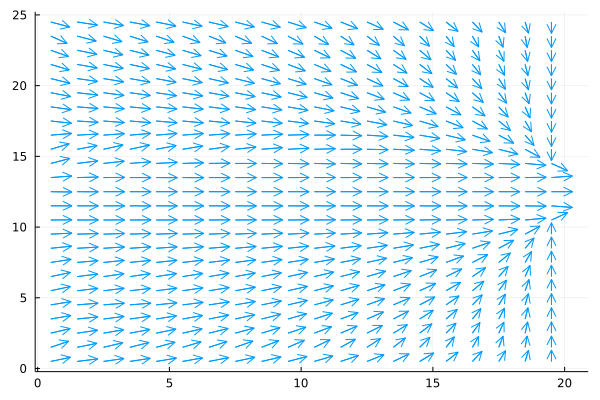

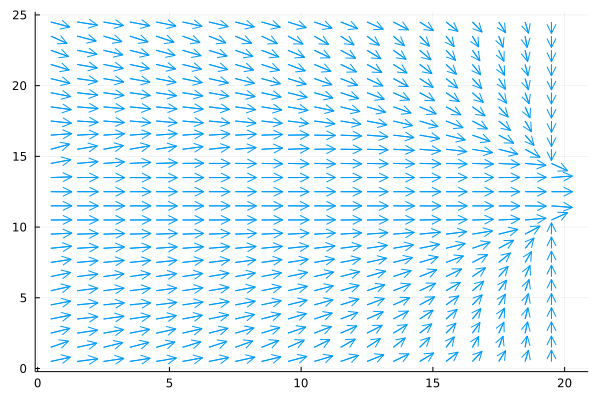

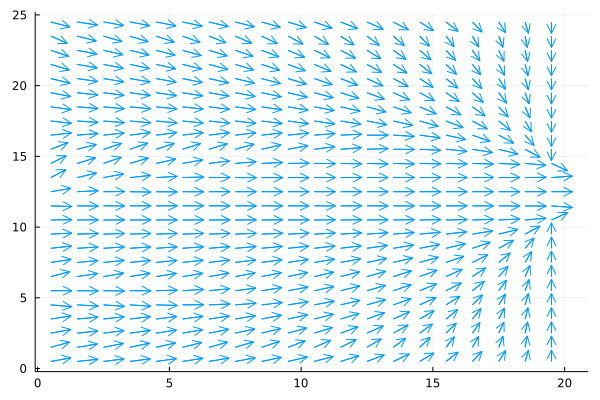

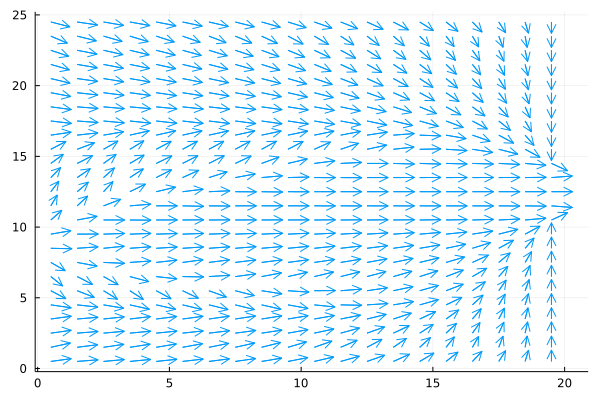

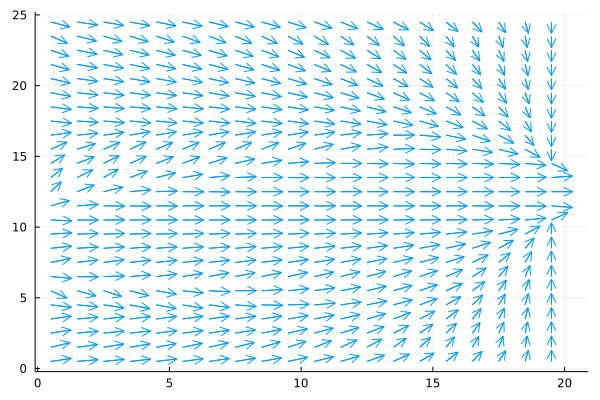

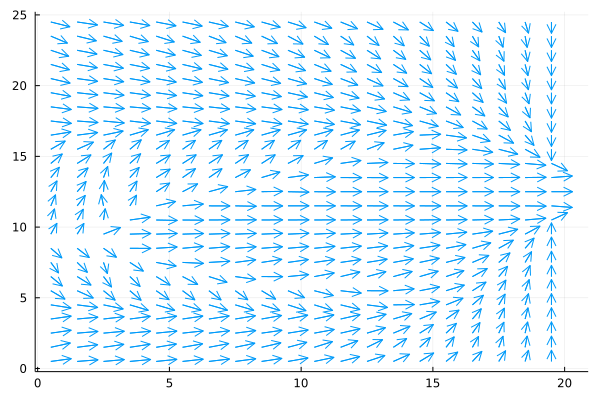

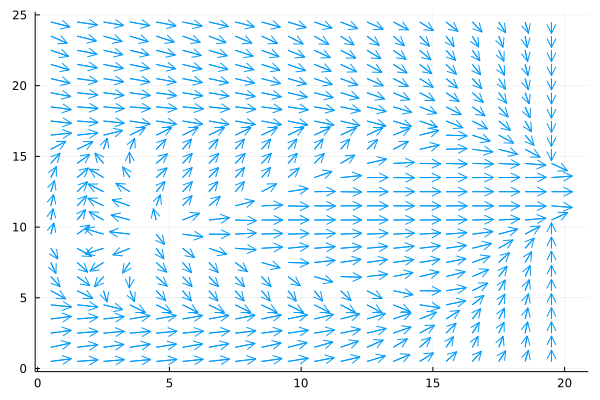

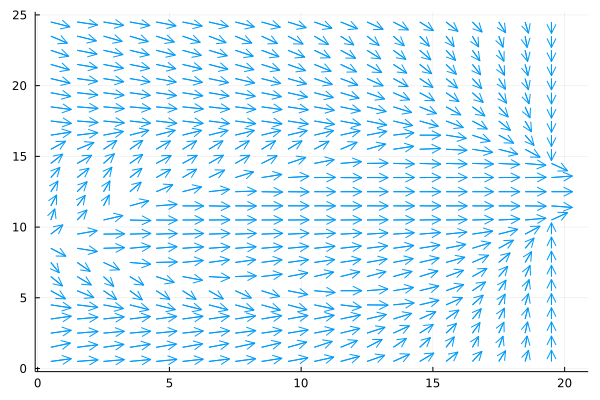

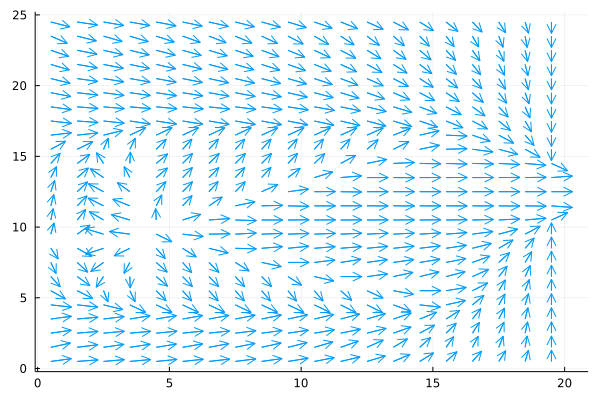

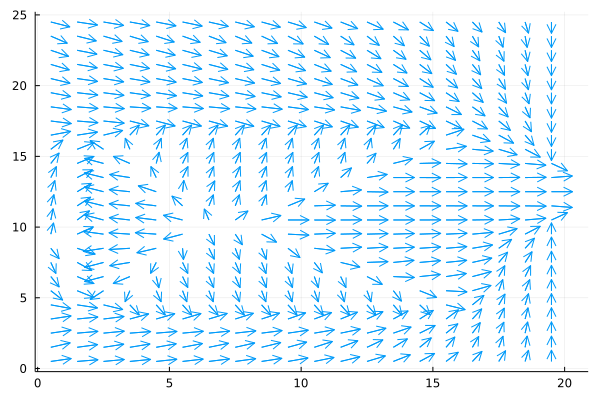

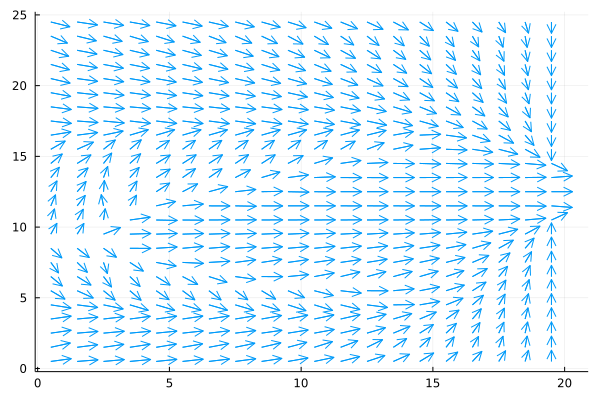

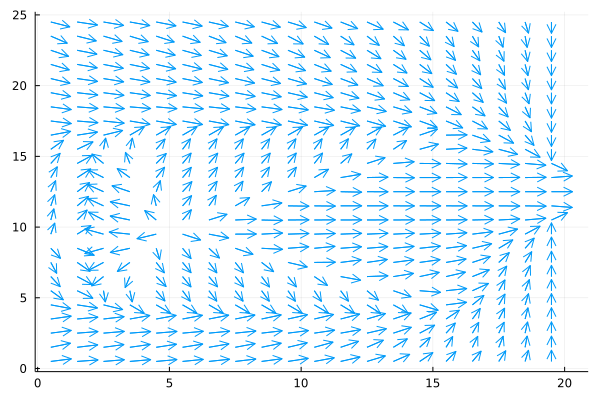

In [9]:
rho_crowded = [0.2, 0.5, 0.8, 0.95]
rho = ones(25,25)*0.05
for rho_c in rho_crowded
    rho[4:16, 6:16] = ones(13,11)*rho_c
    
    #function 1
    phi = CopmutePhi(rho, f1, dx, xRightRoom, yDoorMin, yDoorMax)
    mu_x, mu_y = CalculateMu(phi, xRightRoom, yDoorMin, yDoorMax)
    display(PlotVectorFieldLeft(mu_x, mu_y))
    plot!(size=(400,400))
    savefig("figures//[$(round(rho_c; digits = 2))](f1).png")
    
    #function 2
    phi = CopmutePhi(rho, f2, dx, xRightRoom, yDoorMin, yDoorMax)
    mu_x, mu_y = CalculateMu(phi, xRightRoom, yDoorMin, yDoorMax)
    display(PlotVectorFieldLeft(mu_x, mu_y))
    plot!(size=(400,400))
    savefig("figures//[$(round(rho_c; digits = 2))](f2).png")
    
    #function 3
    phi = CopmutePhi(rho, f3, dx, xRightRoom, yDoorMin, yDoorMax)
    mu_x, mu_y = CalculateMu(phi, xRightRoom, yDoorMin, yDoorMax)
    display(PlotVectorFieldLeft(mu_x, mu_y))
    plot!(size=(400,400))
    savefig("figures//[$(round(rho_c; digits = 2))](f3).png")
end

In [10]:
using MTH229

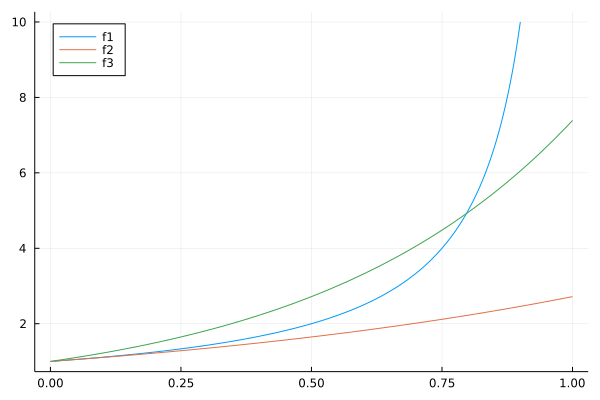

In [11]:
plot(rangeclamp(f1, 10, 1),0 , 1, legend=:topleft, labels="f1")
plot!(f2, 0, 1, labels="f2")
plot!(f3, 0, 1, labels="f3")

In [12]:
savefig("figures//costfunctions.png")

In [13]:
function g(x,y)
    l = ((x-10)^2 + (y-10)^2)^0.5
    rmid = 1
    rcos = 9
    if l < rmid
        return 1
    elseif l > rcos + rmid
        return 0
    end
    return cos((l- 2*rcos - rmid)*pi/(2*rcos))^2
end

g (generic function with 1 method)

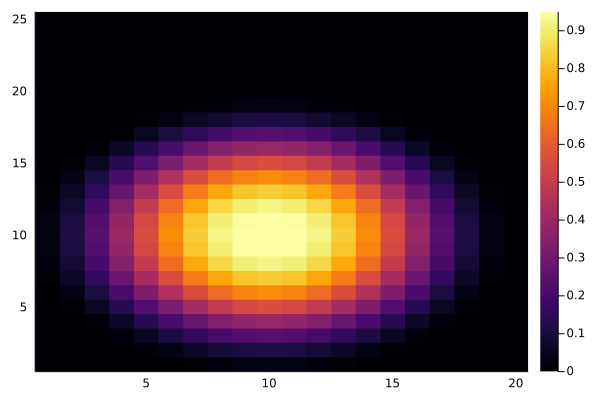

In [14]:
rho = zeros(25,25)
for x in 1:25
    for y in 1:25
        rho[y,x] = g(x,y)*0.95
    end
end
display(heatmap(rho[:,1:20]))
savefig("figures//ContinuousDistribution.png")

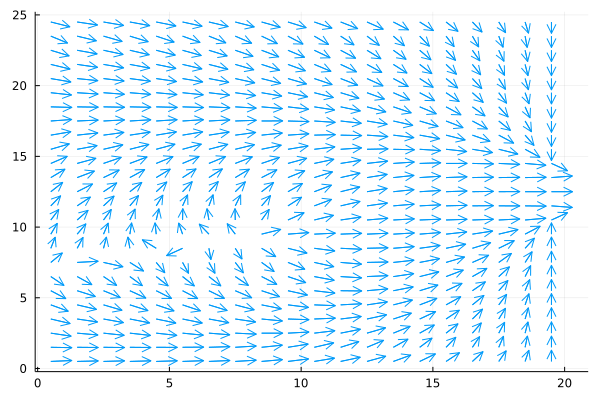

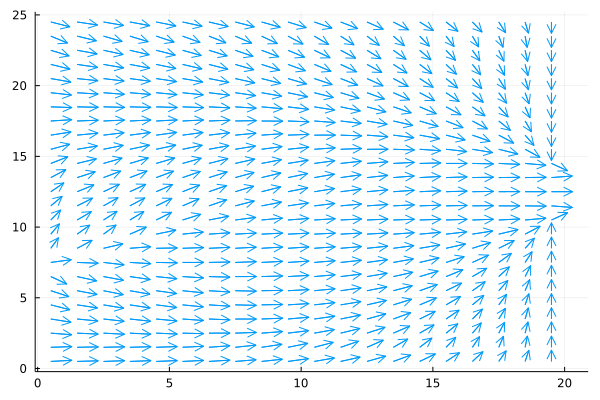

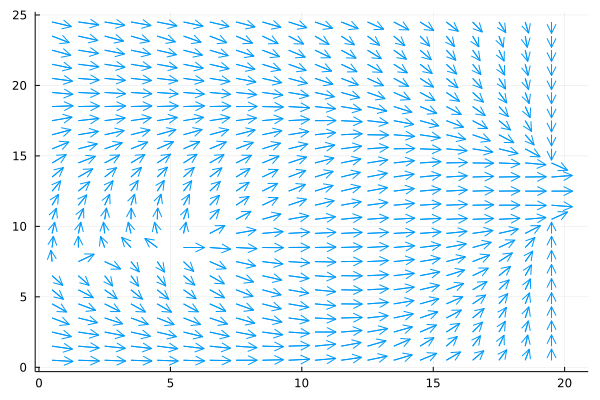

In [15]:
rho_crowded = [0.95]
for rho_c in rho_crowded
    rho = zeros(25,25)
    for x in 1:25
        for y in 1:25
            rho[y,x] = g(x,y) * rho_c
        end
    end
    
    #function 1
    phi = CopmutePhi(rho, f1, dx, xRightRoom, yDoorMin, yDoorMax)
    mu_x, mu_y = CalculateMu(phi, xRightRoom, yDoorMin, yDoorMax)
    display(PlotVectorFieldLeft(mu_x, mu_y))
    plot!(size=(400,400))
    savefig("figures//C[$(round(rho_c; digits = 2))](f1).png")
    heatmap(phi[:,1:20] .- phi[15,21])
    plot!(size=(400,400))
    savefig("figures//H[$(round(rho_c; digits = 2))](f1).png")
    
    #function 2
    phi = CopmutePhi(rho, f2, dx, xRightRoom, yDoorMin, yDoorMax)
    mu_x, mu_y = CalculateMu(phi, xRightRoom, yDoorMin, yDoorMax)
    display(PlotVectorFieldLeft(mu_x, mu_y))
    plot!(size=(400,400))
    savefig("figures//C[$(round(rho_c; digits = 2))](f2).png")
    heatmap(phi[:,1:20] .- phi[15,21])
    plot!(size=(400,400))
    savefig("figures//H[$(round(rho_c; digits = 2))](f2).png")
    
    #function 3
    phi = CopmutePhi(rho, f3, dx, xRightRoom, yDoorMin, yDoorMax)
    mu_x, mu_y = CalculateMu(phi, xRightRoom, yDoorMin, yDoorMax)
    display(PlotVectorFieldLeft(mu_x, mu_y))
    plot!(size=(400,400))
    savefig("figures//C[$(round(rho_c; digits = 2))](f3).png")
    heatmap(phi[:,1:20] .- phi[15,21])
    plot!(size=(400,400))
    savefig("figures//H[$(round(rho_c; digits = 2))](f3).png")
end